# Code

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

import enum

from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics

import ast
import json
import requests
from IPython.display import Image

import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


import difflib as difflib
import random
import datetime


## GYM SET

In [2]:
df_gym = pd.read_csv("megaGymDataset.csv")

In [3]:
#split dataset in features and target variable
feature_cols = [ "Title",	"BodyPart", "Equipment", "Level",	"Rating",	"RatingDesc" ]
X = df_gym[feature_cols] # Features
y = df_gym["Type"] # Target variable

In [4]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [5]:

cats = [ "Type",  "Equipment", "Level", "RatingDesc" ]

df_gym_cat = df_gym

for cat in cats:
  codes, uniques = pd.factorize( df_gym_cat[cat] )
  df_gym_cat[cat] = codes
df_gym_cat['Rating'] = df_gym_cat['Rating'].fillna(0)

codes, uniques = pd.factorize( df_gym['Type'] )


In [6]:
%%capture
feature_cols = [ "Type", "Equipment", "Level",	"Rating",	"RatingDesc" ]

parts = df_gym_cat['BodyPart'].unique()

models = []
partial_dfs = []

for part in parts:
  temp_df = df_gym_cat[df_gym["BodyPart"] == part]
  temp_df.insert(0, 'New_ID', range(1, 1 + len(temp_df)))

  codes, uniques = pd.factorize( temp_df['Type'] )
  temp_df['Type'] = codes


  X = temp_df[feature_cols] # Features
  y = temp_df["New_ID"] # Target variable

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

    # Create Decision Tree classifer object
  clf_gym = DecisionTreeClassifier()

  # Train Decision Tree Classifer
  clf_gym = clf_gym.fit(X_train,y_train)

  #Predict the response for test dataset
  y_pred = clf_gym.predict(X_test)

  

  lst = [[0,	0,	0,	0.0,	-1]]
  df_test = pd.DataFrame(lst, columns = [ "Type", "Equipment", "Level",	"Rating",	"RatingDesc" ])
  df_test
    
  y_sing = clf_gym.predict(df_test)
  models.append(clf_gym)
  partial_dfs.append(temp_df)

## USER CODE

In [7]:

calories1 = pd.read_excel("cal_table.xlsx")
calories1.drop("Наименование", axis=1)
calories3 = pd.read_excel("foods.xlsx")


In [8]:
calories1.rename(columns={'Name': 'food', 
                          'Protein': 'Protein, g', 
                          'Fat': 'Fat, g',
                          'Carbs': 'Carbs, g', 
                          'Calories': 'Calories, kcal'}, inplace=True)


In [9]:
calories = pd.concat([calories1, calories3])
calories.drop("Наименование", axis=1)
calories.reset_index(drop=True)

,Наименование,food,"Protein, g","Fat, g","Carbs, g","Calories, kcal"
0,Абрикосы,apricots,1.0,0.0,10.0,45
1,Авокадо,Avocado,2.0,19.0,7.0,197
2,Аджика,Adjika,2.0,3.0,8.0,59
3,Айва,Quince,1.0,0.0,9.0,41
4,Айсберг,Iceberg,1.0,0.0,2.0,17
...,...,...,...,...,...,...
1387,NaN,Fried egg,18.8,7.6,3.1,213
1388,NaN,Egg powder,20.9,12.9,0.9,243
1389,NaN,boiled egg,37.3,46.0,4.5,542
1390,NaN,Egg with mayonnaise,11.5,12.7,0.7,157


In [10]:
gym_activities = pd.read_excel("gym_activities.xlsx") # calories burnt per 30 minutes

In [11]:


def get_calories(food):
  foods = difflib.get_close_matches(food, calories["food"], n=10, cutoff=0.45)
  if foods:
    food_cal = calories[calories["food"] == foods[0]]
    print(food_cal.values.tolist())
    return food_cal.values.tolist()[0][-1]
  print(f"Food {food} not found!")
  return None

def recommend_exercise(calories_proficit, weight, gym_activities):
  # calories are per 30 minutes
  print(f"You are {calories_proficit} kcal overlimit")
  suggestions = gym_activities[gym_activities["155-pound person"] <= calories_proficit]
  suggestions = suggestions.sample(len(suggestions) // 3 ).sort_values(by=['155-pound person'], ascending=False)
  recommendation = "The following activites can be suggested:\n"
  for item in suggestions.iterrows():

    cal_coef = item[1][1] + (item[1][2] - item[1][1]) / (155-125) * abs(155 - weight*2.205)

    recommendation += f'{item[1][0]} for { int( calories_proficit / ( cal_coef  / 30 ) ) } minutes\n'
  print(recommendation)


def get_exercise(ex, body_part):
  exes = difflib.get_close_matches(ex, df_gym_cat[df_gym_cat["BodyPart"] == body_part]["Title"], n=10, cutoff=0.3)
  if exes:
    exercises = [ df_gym_cat[df_gym_cat['Title'] == x] for x in exes ]
    return exercises
  print(f"Exercises close to {ex} not found!")
  return None
  
a = get_exercise("Bench", "Chest")

In [12]:
running_heartrate = pd.read_csv("running_summary.csv")

In [13]:
running_heartrate = running_heartrate[['heart_rate', 'total_running_time', 'total_calories', 'distance', 'avg_speed']].dropna()


In [14]:
running_train_dataset = running_heartrate.sample(frac=0.8, random_state=0)
running_test_dataset = running_heartrate.drop(running_train_dataset.index)

In [15]:
running_train_features = running_train_dataset.copy()
running_test_features = running_test_dataset.copy()

running_train_labels = running_train_features.pop('heart_rate')
running_test_labels = running_test_features.pop('heart_rate')

In [16]:
%%capture
running_train_dataset.describe().transpose()


In [17]:


normalizer = tf.keras.layers.Normalization(axis=-1)

In [18]:
%%capture
normalizer.adapt(np.array(running_train_features))

first = np.array(running_train_features[:1])

In [19]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [20]:
dnn_model = build_and_compile_model(normalizer)


In [21]:
%%capture
history = dnn_model.fit(
    running_train_features,
    running_train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

In [22]:
test_results = {}
test_results['dnn_model'] = dnn_model.evaluate(running_test_features, running_test_labels, verbose=0)

In [23]:


class Training_Program():
  history = []

class Gender(enum.Enum):
  male = "male"
  female = "female"

class User:
  def __init__(self, name, age, height, weight, gender, ex_type=0, equip=0, level=0):
    self.name = name
    self.age = age
    self.height = height
    self.weight = weight
    self.gender = Gender(gender)
    self.BMI = self.calculate_BMI()

# add calories depending on age
    self.calories_intake = 3000 if self.gender == Gender.male else 2400 
    self.calories_today = 0
    

    self.ex_type = ex_type
    self.equip = equip
    self.level = level

    self.program = None

    self.history = None

  def __str__ (self):
    s = f"""Name: {self.name},
    Age: {self.age},
    Height: {self.height},
    Weight: {self.weight},
    Gender: {self.gender},
    Calories daily: {self.calories_intake},
    Calories today: {self.calories_today},
    BMI: {self.BMI}\n"""

    if self.program:
      s += self.show_program()
    
    return s



# if BMI <= 18.4:
#     print("You are underweight.")
# elif BMI <= 24.9:
#     print("You are healthy.")
# elif BMI <= 29.9:
#     print("You are over weight.")
# elif BMI <= 34.9:
#     print("You are severely over weight.")
# elif BMI <= 39.9:
#     print("You are obese.")
# else:
#     print("You are severely obese.")

  def calculate_BMI(self):
    return self.weight / (self.height/100)**2

  def generate_program(self):
    exercises = {}
    for i in range(len(models)):
      body_part = parts[i]
      model = models[i]
      table = partial_dfs[i]

      lst = [[self.ex_type,	self.equip,	self.level,	0.0,	-1]]
      df_test = pd.DataFrame(lst, columns = [ "Type", "Equipment", "Level",	"Rating",	"RatingDesc" ])

      exercise = model.predict(df_test)
      id = table.index[table['New_ID'] == exercise[0]][0]
      exercises[body_part] = df_gym.iloc[[id]]

    self.program = exercises

    columns = []
    for x in self.program.values():
      y = x['Title'].tolist()[0]
      columns.append(f"{y}, reps")
      columns.append(f"{y}, weight (kg)")
      columns.append(f"{y}, rest (s)")


    
    self.history = pd.DataFrame(columns=columns)
    self.history.insert(0, "Training_number", None)
    self.history.insert(0, "Date", None)

  def show_program(self):
    s = ""
    for i in self.program.keys():
      s += f"For bodypart {i}, recommend { self.program.get(i)['Title'].tolist()[0]}\n"
    return s

  def reset_calories_today(self):
    self.calories_today = 0

  def set_calories_limit(self, limit):
    self.calories_intake = limit


  def calories_calculation(self, foods):
    # cals = 0
    for food in foods:
      self.calories_today += get_calories(food)

    print(f"Total {self.calories_today} kcal eaten today")
    if self.calories_today > self.calories_intake:
      print(f"You are over limit on daily calories, recommend an exercise")
      recommend_exercise(self.calories_today - self.calories_intake, self.weight, gym_activities)
      
    elif self.calories_today < self.calories_intake:
      print(f"Some foods you can eat today:")
      food_vars = calories[calories["Calories, kcal"] <= (self.calories_intake - self.calories_today)]
      print(type(food_vars))
      for index, row in food_vars.iterrows():
        print(f"{row['food']}, kilo calories - {row['Calories, kcal']}")
        if index >= 10:
          break

  
  def get_history(self):
    apptoken = "RQVBQEJyQktGXip6SltGImp2ej48BAAEAAAAAIjiO3VW3QImkgtdJCi7ahfpM592a_DZz09ZaMPA1HhlfA2Hyfgr5qKetRkSKDqF6_2x4abY7bx7wATpFlQdebB0bfCXq9BGQv3JDPVF1TTTSSGxQoEITJgIf6Uxq5wKVWf95EcCrP4oEmUbQkF0aGZPmkC6dC5iHrQGWctKe8004jQjGWA5jmKz8qyMSYSYz"

    r = requests.get('https://api-mifit-de2.huami.com/v1/sport/run/history.json', headers={
        'apptoken': apptoken
    }, params={
        'source': 'run.mifit.huami.com',
    })
    r.raise_for_status()
    return r.json()

  def calc_heartrate(self, model):
    ex = self.get_history()["data"]["summary"][0]
    dist = float(ex["dis"]) / 1000
    speed = (float(ex["dis"]) / 1000) / (float(ex["run_time"]) / 3600)
    calories = float(ex["calorie"])
    time = float(ex["run_time"])
    heart_rate_real = float(ex["avg_heart_rate"])
    print(f"Dist: {dist}, speed: {speed}, cal: {calories}")
    print(f"Actual H/R: {heart_rate_real}")

    # total_running_time	total_calories	distance	avg_speed
    heart_rate_calculated = model.predict([time, calories, dist, speed])
    print(f"Calculated H/R: {heart_rate_calculated}")

    if heart_rate_calculated - heart_rate_real > 5:
      print("Your heart rate is low")
    elif heart_rate_real - heart_rate_calculated > 5:
      print("Your heartrate is high!")
    else:
      print("Your heartrate is normal")



In [24]:
def add_training_results_dummy(user, exercise, weight, reps, rest, t_num, date=datetime.datetime(2023, 5, 17)):
  if not exercise in [x['Title'].tolist()[0] for x in user.program.values()]:
    print("Wrong exercise!")
    return

  ind = len( user.history )
  if user.history.index[user.history['Training_number'] == t_num].tolist():
    ind = user.history.index[user.history['Training_number'] == t_num].tolist()[0]

  user.history.loc[ ind, ["Date"] ] = date
  user.history.loc[ ind, "Training_number" ] = int(t_num)
  user.history.loc[ ind, f"{exercise}, reps"]  = float(reps)
  user.history.loc[ ind, f"{exercise}, weight (kg)" ] = weight
  user.history.loc[ ind, f"{exercise}, rest (s)" ] = rest

  if len(user.history) > 10:
    pass

In [25]:
def add_training_results(user, exercise, weight, reps, rest, t_num, date=datetime.datetime(2023, 5, 17)):
  if not exercise in [x['Title'].tolist()[0] for x in user.program.values()]:
    print("Wrong exercise!")
    return

  ind = len( user.history )
  if user.history.index[user.history['Training_number'] == t_num].tolist():
    ind = user.history.index[user.history['Training_number'] == t_num].tolist()[0]
  
  
  user.history.loc[ ind, ["Date"] ] = date
  user.history.loc[ ind, "Training_number" ] = t_num
  user.history.loc[ ind, f"{exercise}, reps" ] = float(reps)
  user.history.loc[ ind, f"{exercise}, weight (kg)" ] = weight
  user.history.loc[ ind, f"{exercise}, rest (s)" ] = rest


  if len(user.history) > 10:
    w, b = get_recommended_weights(user.history, exercise)
    predict = get_predicted_weight(user.history, my_output, w, b, weight, reps)



In [26]:


def choose_exercise_num(n):
  choice = -1
  
  while choice < 0 or choice > n:
    try:
      choice = int(input()) - 1
    except:
      print("Please enter a valid number")
  return choice


def change_exercise(user: User, body_part: str, new_exercise: str, gym_set):
  
  if body_part in list(df_gym_cat["BodyPart"].unique()) :
    ex = get_exercise(new_exercise, body_part=body_part)
    print(f"Found following exercises:")
    for i in range(len(ex)):
      print(f"Number {i + 1}) - {list(ex[i]['Title'])[0] }")
    print("Enter the number of the exercise to choose:")

    choice = choose_exercise_num(len(ex))

    title = list(ex[choice]['Title'])[0]
    print(f"Chose exercise {title}")
    
    user.program[body_part] = ex[choice]

    user.history[f"{title}, reps"] = np.nan
    user.history[f"{title}, weight (kg)"] = np.nan
    user.history[f"{title}, rest (s)"] = np.nan
  else:
    print(f"Bodypart {body_part} not found")


## Map Search

In [27]:
test_long = 37.44338754155181
test_lat = 55.83872304132719

In [28]:
%%capture

ya_api = "be69a8a0-9ea0-42cf-ad7a-5b73199a308d"

req_str = f"https://search-maps.yandex.ru/v1/?"\
  "text=Спортивная площадка&"\
  f"ll={test_long},{test_lat}&"\
  "spn=0.552069,0.550552&"\
  "type=biz&"\
  "results=5&"\
  "lang=ru_RU&"\
  f"apikey={ya_api}"
print(req_str)

x = requests.get(req_str)


In [29]:


def get_all_coordinates(x):
  gym_coordinates = []
  for item in x.json()["features"]:
    gym_coordinates.append(item["geometry"]["coordinates"])
  return gym_coordinates

gym_coordinates = get_all_coordinates(x)

## Getting the map

In [30]:
# 37.620070,55.753630,pmwtm12~37.64,55.76363,pmwtm99

def points_create(l):
  points = []
  
  for item in l:
    points.append(f"{item[0]},{item[1]},pm2wtm{l.index(item) + 1}")
  return "~".join(points)

In [31]:

map = requests.get(f"""https://static-maps.yandex.ru/1.x/?ll={test_long},{test_lat}&size=450,450&z=11&l=map&pt={points_create(gym_coordinates)}""")
# display(Image(map.content))

## How to get location (Lat and long)

In [32]:

ip_stack_key = "e51b2f79be62ac3ac1f0932cefcd4123"

send_url = f"http://api.ipstack.com/check?access_key={ip_stack_key}"
geo_req = requests.get(send_url)
geo_json = json.loads(geo_req.text)
latitude = geo_json['latitude']
longitude = geo_json['longitude']
city = geo_json['city']
# geo_json

Градусы в минуты и секунды

In [33]:


def get_min_sec(rad):
  ans = []
  r = math.floor(rad)
  # print(r)
  ans.append(r)
  m = (rad - math.floor(rad)) * 60
  print(m)
  ans.append(round(m, 4))
  s = round((m - math.floor(m)) * 60, 2)
  print(s)
  ans.append((round(s, 4)))
  return ans


In [34]:
req_str = f"https://search-maps.yandex.ru/v1/?"\
  "text=Спортивная площадка&"\
  f"ll={test_long},{test_lat}&"\
  "spn=0.552069,0.550552&"\
  "type=biz&"\
  "results=70&"\
  "lang=ru_RU&"\
  f"apikey={ya_api}"

y = requests.get(req_str)


In [35]:


lat_start = random.uniform(-0.09, 0.09)
long_start = random.uniform(-0.09, 0.09)
lat_end = random.uniform(-0.09, 0.09)
long_end = random.uniform(-0.09, 0.09)


In [36]:


points = get_all_coordinates(y)

map = requests.get(f"""https://static-maps.yandex.ru/1.x/?ll={test_long},{test_lat}&size=450,450&z=11&l=map&pt={points_create(points)}"""\
                   f"&pl={test_long + long_start},{test_lat + lat_start},{test_long + long_end},{test_lat + lat_end}")


In [37]:
def coord_distance(x1, y1, x2, y2):
  # print(f"{x1}, {y1}, {x2}, {y2}")
  return math.sqrt( (x2 - x1)**2 + (y2 - y1)**2 )

def notification_gym_nearby(point, distance):
  print(f"Notification sent, point {point}. distance {round(distance * 100000, 2)}")

In [38]:

flag_point = 0

def find_closes_gym(long, lat, gyms):
  
  global flag_point
  closest = 0
  min_dist = 100
  for j in gyms:
    d = coord_distance(long, lat, j[0], j[1]) 
    if d < dist:
      if d < min_dist:
        min_dist = d
        closest = points.index(j) + 1
        

  if closest:
    print(f"Closest point is {closest}, in {round(min_dist * 100000, 2)} meters!")
    
    if closest != flag_point:
      notification_gym_nearby(closest, min_dist)
      flag_point = closest

  else:
    print("No closest point...")

steps = 100
dist = 0.01


## Smart watches

In [39]:
def get_detail(track_id, source):
    r = requests.get('https://api-mifit-de2.huami.com/v1/sport/run/detail.json', headers={
        'apptoken': apptoken
    }, params={
        'trackid': track_id,
        'source': source,
    })
    r.raise_for_status()

    return r.json()


In [40]:
def show_graphs(exercise_history):
  for data in ["dis", "total_step",  "calorie", "run_time", "avg_heart_rate"]:
    y = []
    for item in exercise_history["data"]["summary"]:
      
      y.append(float(item[data]))
    x = [ i for i in range(len(exercise_history["data"]["summary"])) ]
    
    plt.title(f"Information on: {data}")
    plt.xlabel(f"Training session number")
    plt.ylabel(f"{data}")

    plt.plot(x, y)

    
    plt.xticks(np.arange(min(x), max(x)+1, 1.0)) 

    plt.grid()

    plt.show()


In [41]:
running_heartrate = pd.read_csv("running_summary.csv")

In [42]:
running_heartrate = running_heartrate[['heart_rate', 'total_running_time', 'total_calories', 'distance', 'avg_speed']].dropna()


In [43]:
running_train_dataset = running_heartrate.sample(frac=0.8, random_state=0)
running_test_dataset = running_heartrate.drop(running_train_dataset.index)

In [44]:
running_train_features = running_train_dataset.copy()
running_test_features = running_test_dataset.copy()

running_train_labels = running_train_features.pop('heart_rate')
running_test_labels = running_test_features.pop('heart_rate')

In [45]:
%%capture
running_train_dataset.describe().transpose()


In [46]:
normalizer = tf.keras.layers.Normalization(axis=-1)

In [47]:

normalizer.adapt(np.array(running_train_features))

first = np.array(running_train_features[:1])



In [48]:
def my_output(X, weights, biases):
    return tf.add(tf.multiply(X, weights), biases)

def loss_func(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_pred - y_true))



def get_recommended_weights(tr_history, ex_name):
  x_vals =  tr_history[f"{ex_name}, reps"].astype(np.float32).to_numpy()
  y_vals = tr_history[f"{ex_name}, weight (kg)"].astype(np.float32).to_numpy()
  norm = np.linalg.norm(x_vals)     # To find the norm of the array
  normalized_array = x_vals/norm  # Formula used to perform array normalization


  my_opt = tf.optimizers.SGD(learning_rate=0.02)
  tf.random.set_seed(1)
  np.random.seed(0)
  weights = tf.Variable(tf.random.normal(shape=[1])) 
  biases = tf.Variable(tf.random.normal(shape=[1])) 
  history = list()

  for i in range(len(x_vals)): 
    rand_index = np.random.choice(len(x_vals))
    rand_x = [normalized_array[rand_index]] 
    rand_y = [y_vals[rand_index]]
    with tf.GradientTape() as tape:
        predictions = my_output(rand_x, weights, biases)
        loss = loss_func(rand_y, predictions)
    history.append(loss.numpy())
    gradients = tape.gradient(loss, [weights, biases])
    my_opt.apply_gradients(zip(gradients, [weights, biases]))
  return weights, biases


In [49]:


def plot_reps(history, exercise):
  history = history.astype({"Training_number": int, f"{exercise}, reps": float, f"{exercise}, weight (kg)": float})
  
  sns.lmplot(x=f"Training_number" ,y=f"{exercise}, reps" ,data=history, fit_reg=True) 
  sns.lmplot(x=f"Training_number" ,y=f"{exercise}, weight (kg)" ,data=history, fit_reg=True) 

  df_temp = history[["Date", f"{exercise}, reps", f"{exercise}, weight (kg)"]].copy()
  df_temp["dates"] = pd.to_datetime(history['Date']).apply(lambda date: date.toordinal())
  ax = sns.regplot(
    data=df_temp,
    x="dates",
    y=f"{exercise}, reps",
  )
  # Tighten up the axes for prettiness
  ax.set_xlim(df_temp['dates'].min() - 1, df_temp['dates'].max() + 1)
  ax.set_ylim(0, df_temp[f"{exercise}, reps"].max() + 1)
  # Replace the ordinal X-axis labels with nice, readable dates
  ax.set_xlabel('Date')
  new_labels = [datetime.date.fromordinal(int(item)) for item in ax.get_xticks()]
  ax.set_xticklabels(new_labels)
  ax.tick_params(axis='x', rotation=90)


def plot_weights(history, exercise):
  history = history.astype({"Training_number": int, f"{exercise}, reps": float, f"{exercise}, weight (kg)": float})
  
  sns.lmplot(x=f"Training_number" ,y=f"{exercise}, weight (kg)" ,data=history, fit_reg=True) 

  df_temp = history[["Date", f"{exercise}, reps", f"{exercise}, weight (kg)"]].copy()
  df_temp["dates"] = pd.to_datetime(history['Date']).apply(lambda date: date.toordinal())
  ax = sns.regplot(
    data=df_temp,
    x="dates",
    y=f"{exercise}, reps",
  )
  # Tighten up the axes for prettiness
  ax.set_xlim(df_temp['dates'].min() - 1, df_temp['dates'].max() + 1)
  ax.set_ylim(0, df_temp[f"{exercise}, weight (kg)"].max() + 1)
  # Replace the ordinal X-axis labels with nice, readable dates
  ax.set_xlabel('Date')
  new_labels = [datetime.date.fromordinal(int(item)) for item in ax.get_xticks()]
  ax.set_xticklabels(new_labels)
  ax.tick_params(axis='x', rotation=90)



In [50]:
def get_predicted_weight(history, model, w, b, weights, reps):
  pred_w = round(float(model(float(reps), w, b)), 2) / 2
  print(f"Predicted weights: {pred_w}, actual weights: {weights}")
  if pred_w > weights:
    print("Good weights, recommend increasing reps")
  else:
    print("Recommend increasing weights")


# Example

### Creating a new user

In [51]:
person = User("Ivan", 25, 180, 90, "male", ex_type=1)
print(person)

Name: Ivan,
    Age: 25,
    Height: 180,
    Weight: 90,
    Gender: Gender.male,
    Calories daily: 3000,
    Calories today: 0,
    BMI: 27.777777777777775



### Generate a program for that user

In [52]:
person.generate_program()
print(person.show_program())

For bodypart Abdominals, recommend Banded crunch isometric hold
For bodypart Adductors, recommend Carioca quick step
For bodypart Abductors, recommend Lateral Band Walk
For bodypart Biceps, recommend Incline dumbbell biceps curl
For bodypart Calves, recommend Smith machine standing calf raise
For bodypart Chest, recommend Bench Press With Short Bands
For bodypart Forearms, recommend Standing alternating band speed row
For bodypart Glutes, recommend Alternating standing glute stretch
For bodypart Hamstrings, recommend 30 Legs Sumo Deadlift
For bodypart Lats, recommend UN Band Assisted Pull-up Neutral
For bodypart Lower Back, recommend Reverse Band Deadlift
For bodypart Middle Back, recommend Partner side plank band row
For bodypart Traps, recommend Snatch Shrug
For bodypart Neck, recommend Side Neck Stretch
For bodypart Quadriceps, recommend Speed Box Squat
For bodypart Shoulders, recommend HM Lateral Raise
For bodypart Triceps, recommend Reverse Band Bench Press



### Let us show what happens if food is eaten

In [53]:


food_list = ["Egg", "Pie", "Chicken", "Sandwich, Spaghetti"]

person.calories_calculation(food_list)

[['Яйца', 'Eggs', 15.0, 13.0, 1.0, 162]]
[['Соленый огурец', 'Pickle', 1.0, 0.0, 3.0, 14]]
[['Курица', 'Chicken', 21.0, 11.0, 1.0, 186]]
[[nan, 'Steamed beef patties', 11.3, 16.7, 5.9, 193]]
Total 555 kcal eaten today
Some foods you can eat today:
<class 'pandas.core.frame.DataFrame'>
apricots, kilo calories - 45
Avocado, kilo calories - 197
Adjika, kilo calories - 59
Quince, kilo calories - 41
Iceberg, kilo calories - 17
Activia kefir 1%, kilo calories - 39
A pineapple, kilo calories - 50
Canned pineapple, kilo calories - 65
candied pineapple, kilo calories - 78
Orange, kilo calories - 43
Orange juice, kilo calories - 44


### Set a new daily calorie limit, reset daily calories and try other food

In [54]:
person.reset_calories_today()
person.set_calories_limit(400)

new_food_list = ["Cheese", "Oatmeal"]
person.calories_calculation(new_food_list)

[['Сыр 45%', 'Cheese 45%', 26.0, 26.0, 0.0, 336]]
[['Овсянка', 'Oatmeal', 9.0, 5.0, 46.0, 271]]
Total 607 kcal eaten today
You are over limit on daily calories, recommend an exercise
You are 207 kcal overlimit
The following activites can be suggested:
Golf: carrying clubs for 29 minutes
Whitewater: rafting, kayaking for 32 minutes
Paint, paper, remodel: inside for 32 minutes
Gardening: general for 35 minutes
Heavy Cleaning: wash car, windows for 35 minutes
Stretching, Hatha Yoga for 40 minutes
Bowling for 53 minutes
Weight Lifting: general for 53 minutes
Water Volleyball for 53 minutes
Food Shopping: with cart for 53 minutes
Reading: sitting for 145 minutes
Sleeping for 266 minutes



### Add an exercise after training session

In [55]:
# So that the example works, as the program is be generated
test_exec = [x['Title'].tolist()[0] for x in person.program.values()][0]

add_training_results_dummy(person, test_exec, 10, 26, 42, 2, date=datetime.datetime(2020, 5, 18))
person.history

,Date,Training_number,"Banded crunch isometric hold, reps","Banded crunch isometric hold, weight (kg)","Banded crunch isometric hold, rest (s)","Carioca quick step, reps","Carioca quick step, weight (kg)","Carioca quick step, rest (s)","Lateral Band Walk, reps","Lateral Band Walk, weight (kg)",...,"Side Neck Stretch, rest (s)","Speed Box Squat, reps","Speed Box Squat, weight (kg)","Speed Box Squat, rest (s)","HM Lateral Raise, reps","HM Lateral Raise, weight (kg)","HM Lateral Raise, rest (s)","Reverse Band Bench Press, reps","Reverse Band Bench Press, weight (kg)","Reverse Band Bench Press, rest (s)"
0,2020-05-18 00:00:00,2,26.0,10,42,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Can change an exercise from the program 

In [56]:
print("Before:")
print(person)
change_exercise(person, "Abdominals", "Chest", df_gym_cat)
print("\n\nAfter:")
print(person)

Before:
Name: Ivan,
    Age: 25,
    Height: 180,
    Weight: 90,
    Gender: Gender.male,
    Calories daily: 400,
    Calories today: 607,
    BMI: 27.777777777777775
For bodypart Abdominals, recommend Banded crunch isometric hold
For bodypart Adductors, recommend Carioca quick step
For bodypart Abductors, recommend Lateral Band Walk
For bodypart Biceps, recommend Incline dumbbell biceps curl
For bodypart Calves, recommend Smith machine standing calf raise
For bodypart Chest, recommend Bench Press With Short Bands
For bodypart Forearms, recommend Standing alternating band speed row
For bodypart Glutes, recommend Alternating standing glute stretch
For bodypart Hamstrings, recommend 30 Legs Sumo Deadlift
For bodypart Lats, recommend UN Band Assisted Pull-up Neutral
For bodypart Lower Back, recommend Reverse Band Deadlift
For bodypart Middle Back, recommend Partner side plank band row
For bodypart Traps, recommend Snatch Shrug
For bodypart Neck, recommend Side Neck Stretch
For bodypart 

In [57]:
person.history

,Date,Training_number,"Banded crunch isometric hold, reps","Banded crunch isometric hold, weight (kg)","Banded crunch isometric hold, rest (s)","Carioca quick step, reps","Carioca quick step, weight (kg)","Carioca quick step, rest (s)","Lateral Band Walk, reps","Lateral Band Walk, weight (kg)",...,"Speed Box Squat, rest (s)","HM Lateral Raise, reps","HM Lateral Raise, weight (kg)","HM Lateral Raise, rest (s)","Reverse Band Bench Press, reps","Reverse Band Bench Press, weight (kg)","Reverse Band Bench Press, rest (s)","Weighted Crunches, reps","Weighted Crunches, weight (kg)","Weighted Crunches, rest (s)"
0,2020-05-18 00:00:00,2,26.0,10,42,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Can locate nearby sports ground based on location

Use Pokrovka HSE Campus as an example of coordinates

In [58]:
HSE_long = 37.64823890522192
HSE_lat = 55.75362365163729

In [59]:
req_str = f"https://search-maps.yandex.ru/v1/?"\
  "text=Спортивная площадка&"\
  f"ll={HSE_long},{HSE_lat}&"\
  "spn=0.552069,0.550552&"\
  "type=biz&"\
  "results=15&"\
  "lang=ru_RU&"\
  f"apikey={ya_api}"
# print(req_str)

x = requests.get(req_str)
gym_coordinates = get_all_coordinates(x)

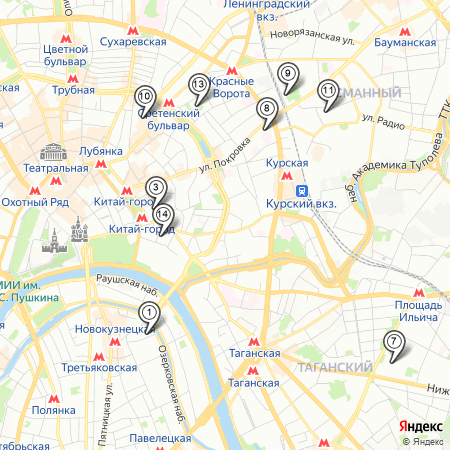

In [60]:
HSE_map = requests.get(f"""https://static-maps.yandex.ru/1.x/?ll={HSE_long},{HSE_lat}&size=450,450&z=13&l=map&pt={points_create(gym_coordinates)}""")
display(Image(HSE_map.content))

### Now suppose we walk along a line near by close-by sport grounds

In [61]:

long_start = 37.63912337086539
lat_start = 55.7531586027803

In [62]:

long_end = 37.63468163273671
lat_end = 55.75671621603898

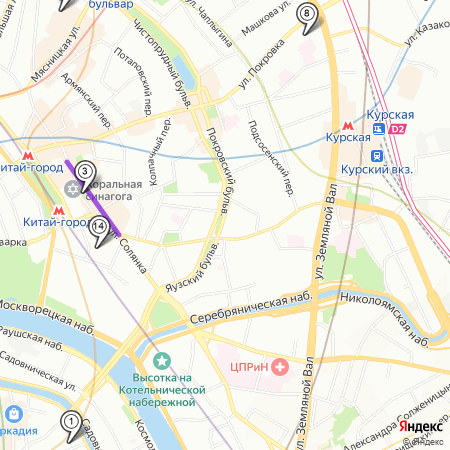

In [63]:

points = get_all_coordinates(x)

map = requests.get(f"""https://static-maps.yandex.ru/1.x/?ll={HSE_long},{HSE_lat}&size=450,450&z=14&l=map&pt={points_create(points)}"""\
                   f"&pl={long_start},{lat_start},{long_end},{lat_end}")
display(Image(map.content))

### So here the service shows nearby locations and distance to them

the cycle is a rough simulation of walking along the line, on each step find the closest

In [64]:


steps = 100
dist = 0.01

for i in range(steps):
  cur_lat = lat_start + (lat_end - lat_start) * i / steps
  cur_long = long_start + (long_end - long_start) * i / steps
  find_closes_gym(cur_long, cur_lat, points)

Closest point is 14, in 195.3 meters!
Notification sent, point 14. distance 195.3
Closest point is 14, in 192.24 meters!
Closest point is 14, in 189.32 meters!
Closest point is 14, in 186.52 meters!
Closest point is 14, in 183.85 meters!
Closest point is 14, in 181.32 meters!
Closest point is 14, in 178.94 meters!
Closest point is 14, in 176.71 meters!
Closest point is 14, in 174.63 meters!
Closest point is 14, in 172.72 meters!
Closest point is 14, in 170.98 meters!
Closest point is 14, in 169.41 meters!
Closest point is 14, in 168.02 meters!
Closest point is 14, in 166.81 meters!
Closest point is 14, in 165.79 meters!
Closest point is 14, in 164.95 meters!
Closest point is 14, in 164.31 meters!
Closest point is 14, in 163.87 meters!
Closest point is 14, in 163.62 meters!
Closest point is 14, in 163.57 meters!
Closest point is 14, in 163.72 meters!
Closest point is 14, in 164.07 meters!
Closest point is 14, in 164.61 meters!
Closest point is 14, in 165.35 meters!
Closest point is 14, 

### Can show graphical info on progress

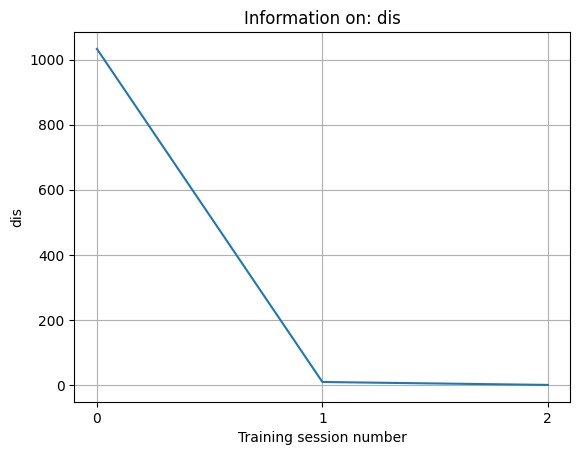

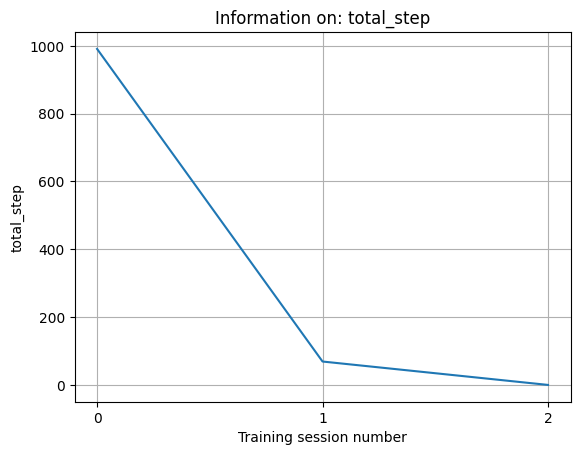

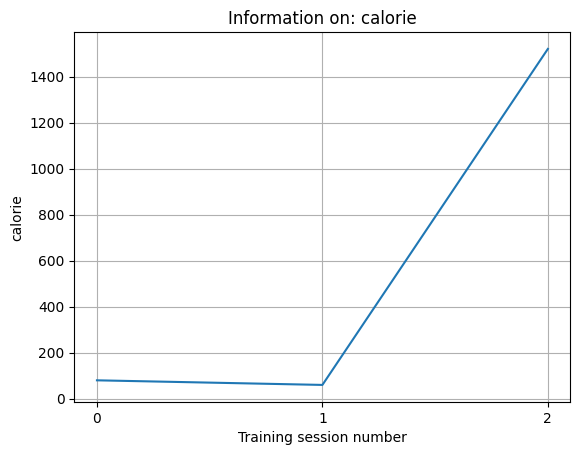

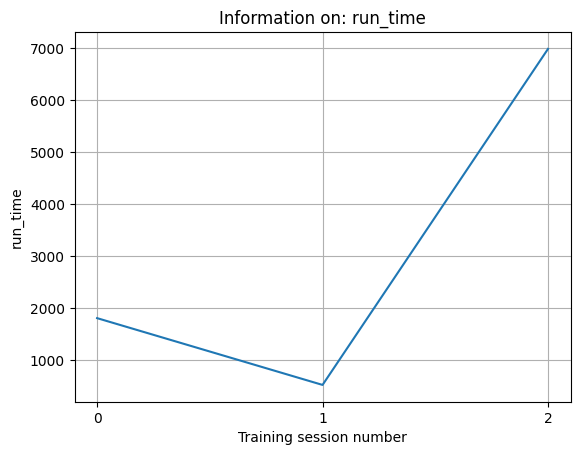

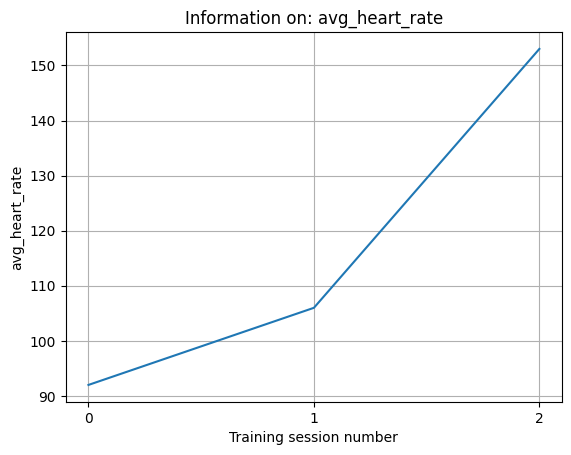

In [65]:
show_graphs(person.get_history())

Can try to claculate and predict the heartbeat rat, then compare it with the one from user's training

In [66]:
person.calc_heartrate(dnn_model)

Dist: 1.033, speed: 2.061419068736142, cal: 80.0
Actual H/R: 92.0
1/1 [==============================] - 0s 135ms/step
Calculated H/R: [[208.12857]]
Your heart rate is low


For some given exercise, can plot user's progress

In [67]:
# Get the exercise from the program to examie
test_ex = list(person.program["Abdominals"]["Title"])[0]
test_ex

'Weighted Crunches'

In [68]:

add_training_results(person, "Lateral Band Walk", 10, 26, 42, 0, date=datetime.datetime(2023, 5, 19))
person.history

,Date,Training_number,"Banded crunch isometric hold, reps","Banded crunch isometric hold, weight (kg)","Banded crunch isometric hold, rest (s)","Carioca quick step, reps","Carioca quick step, weight (kg)","Carioca quick step, rest (s)","Lateral Band Walk, reps","Lateral Band Walk, weight (kg)",...,"Speed Box Squat, rest (s)","HM Lateral Raise, reps","HM Lateral Raise, weight (kg)","HM Lateral Raise, rest (s)","Reverse Band Bench Press, reps","Reverse Band Bench Press, weight (kg)","Reverse Band Bench Press, rest (s)","Weighted Crunches, reps","Weighted Crunches, weight (kg)","Weighted Crunches, rest (s)"
0,2020-05-18 00:00:00,2,26.0,10,42,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-05-19 00:00:00,0,NaN,NaN,NaN,NaN,NaN,NaN,26.0,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [69]:
# filling history with dummy data
for i in range(100):
  a = round(random.uniform(7, 30), 0)
  b = round(random.uniform(15, 25), 0)
  add_training_results(person, test_ex, 
                       a + (i // 8), 
                       b + (i // 8), 
                       round(random.uniform(30, 45), 0),
                       i,
                       datetime.datetime(2023, 5, 18) + datetime.timedelta(days= (i // 3) )
)
  

Predicted weights: 18.03, actual weights: 11.0
Good weights, recommend increasing reps
Predicted weights: 14.815, actual weights: 14.0
Good weights, recommend increasing reps
Predicted weights: 16.02, actual weights: 21.0
Recommend increasing weights
Predicted weights: 20.02, actual weights: 30.0
Recommend increasing weights
Predicted weights: 18.23, actual weights: 9.0
Good weights, recommend increasing reps
Predicted weights: 19.375, actual weights: 9.0
Good weights, recommend increasing reps
Predicted weights: 17.965, actual weights: 30.0
Recommend increasing weights
Predicted weights: 22.645, actual weights: 32.0
Recommend increasing weights
Predicted weights: 26.995, actual weights: 28.0
Recommend increasing weights
Predicted weights: 26.13, actual weights: 11.0
Good weights, recommend increasing reps
Predicted weights: 26.61, actual weights: 11.0
Good weights, recommend increasing reps
Predicted weights: 20.405, actual weights: 16.0
Good weights, recommend increasing reps
Predict

<ipython-input-49-147db82235e0>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_labels)
<ipython-input-49-147db82235e0>:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_labels)


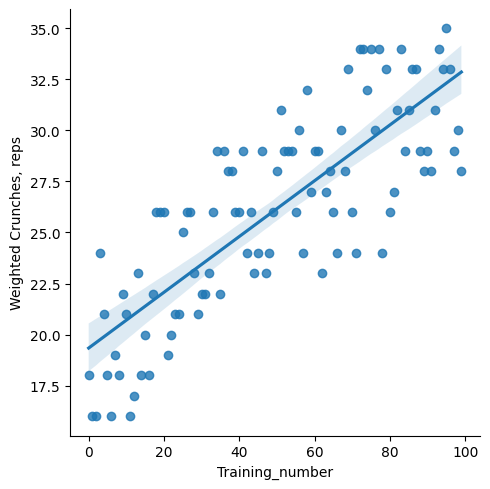

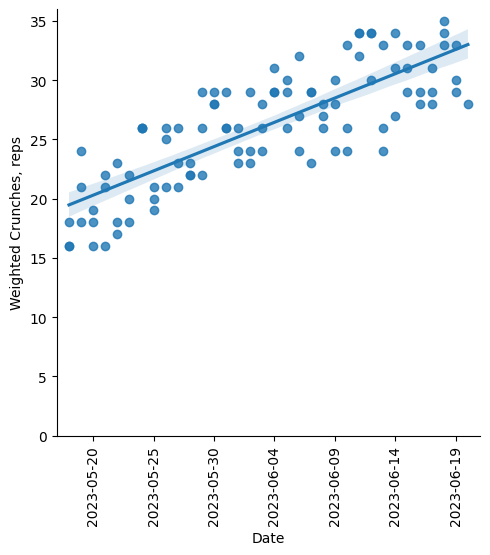

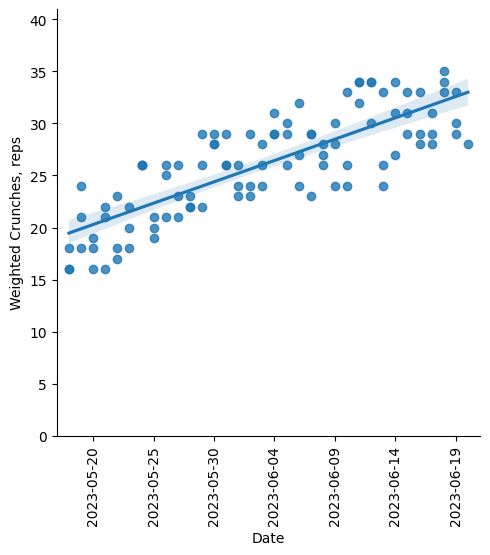

In [70]:



plot_reps(person.history, test_ex)
plot_weights(person.history, test_ex)